# Idea

To simulate the benefit of online data aquisition, we need access to a spatially continous "ground truth" function. Here we will use BedMachince data as the hypothetical **ground truth**. 

Online BO (also called sequential BO) is the opposite to Batch BO or paralell BO, where we evaluate the function (i.e. retrieve an ice thickness measurement) directly after visiting every location. We will still use past survey locations from the Bedmap collection for realistic data scenario. Hence, the resulting setting can be described as a hybrid of real and simulated/modelled.

In practice this might be more feasible with UAV surveys, like drone-based ice penetrating radars: 
- Peregrine, Thomas Teisberg [see article](https://spectrum.ieee.org/drone-ice-radar)
- [paper](https://www.mdpi.com/2072-4292/16/13/2461)

In [2]:
import xarray as xr
import pandas as d
import numpy as np
import torch

from scipy.interpolate import RegularGridInterpolator

In [3]:
path_to_bedmachine_on_server = "/home/kim/data/nsidc/BedMachineAntarctica-v3.nc"
bm = xr.load_dataset(path_to_bedmachine_on_server)

path_to_bedmap3_on_server = "/home/kim/data/bedmap3/bedmap3.nc"
bmap3 = xr.load_dataset(path_to_bedmap3_on_server)

In [4]:
# Region around Casey
x_min = 1_300_000
x_max = 2_700_000
y_min = - 1_600_000
y_max = - 200_000

bm_casey = bm.sel(x = slice(x_min, x_max), y = slice(y_max, y_min))
bmap3_casey = bmap3.sel(x = slice(x_min, x_max), y = slice(y_max, y_min))

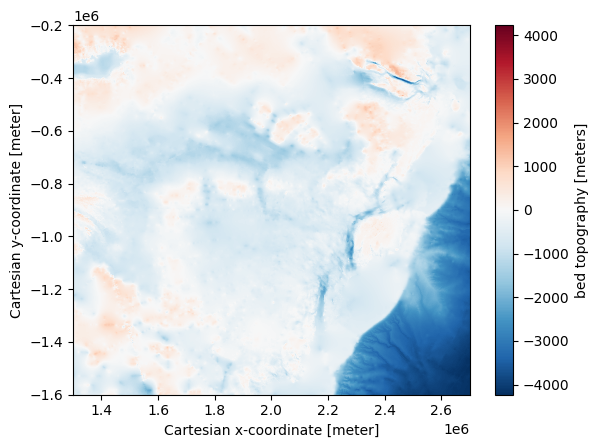

In [5]:
bm_casey.bed.plot()

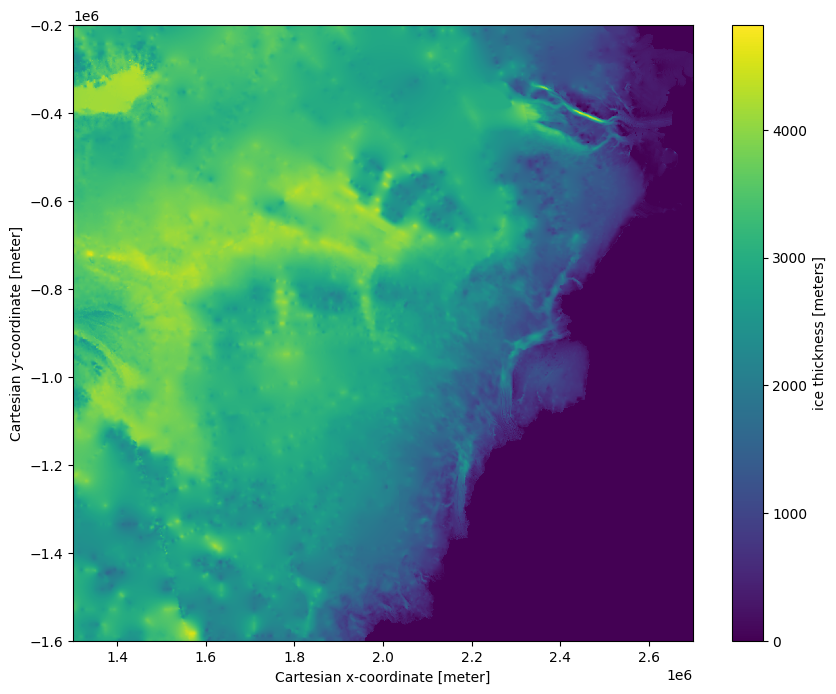

In [6]:
# Make it a bit bigger than usual
bm_casey.thickness.plot(figsize = (10, 8))
### COARSEN ###
# boundry = 'exact' does not always work
# bm_casey.thickness.coarsen(x = 10, y = 10, boundary = 'trim').mean().plot(figsize = (10, 8))

In [7]:
bmap3_casey

<xarray.Dataset> Size: 220MB
Dimensions:                 (x: 2800, y: 2800)
Coordinates:
  * x                       (x) float32 11kB 1.3e+06 1.301e+06 ... 2.7e+06
  * y                       (y) float32 11kB -2.002e+05 -2.008e+05 ... -1.6e+06
Data variables:
    surface_topography      (y, x) float32 31MB 3.705e+03 3.705e+03 ... nan nan
    bed_uncertainty         (y, x) float32 31MB 131.0 128.0 ... 165.0 169.0
    bed_topography          (y, x) float32 31MB 146.0 139.0 ... -4.198e+03
    mask                    (y, x) float32 31MB 1.0 1.0 1.0 1.0 ... nan nan nan
    ice_thickness           (y, x) float32 31MB 3.559e+03 3.566e+03 ... nan nan
    thickness_survey_count  (y, x) float32 31MB nan nan nan nan ... nan nan nan
    thickness_uncertainty   (y, x) float32 31MB 131.0 128.0 126.0 ... nan nan
    mapping                 <U19 76B 'polar_stereographic'
Attributes: (12/26)
    crs:                    EPSG:3031
    title:                  BEDMAP3 - Ice thickness, bed and surface elevatio...
    summary:                We present here Bedmap3, the latest suite of grid...
    keywords:               Antarctica,BEDMAP,Elevation,Ice thickness
    Conventions:            ACDD-1.3, CF-1.8
    citation:               Pritchard, H., Fretwell, P., Fremand, A., Bodart,...
    ...                     ...
    time_coverage_end:      2024-11-01
    geospatial_lon_min:     -180
    geospatial_lon_max:     180
    geospatial_lat_min:     -90
    geospatial_lat_max:     -60
    geospatial_bounds_crs:  EPSG:4326

# Visualise in 3D

/home/kim/anaconda3/envs/bo4ais_env/lib/python3.10/site-packages/pyvista/core/utilities/points.py:79: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(
2025-10-08 14:25:40.510 (   1.736s) [    7F7D425D2180]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=
/home/kim/anaconda3/envs/bo4ais_env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


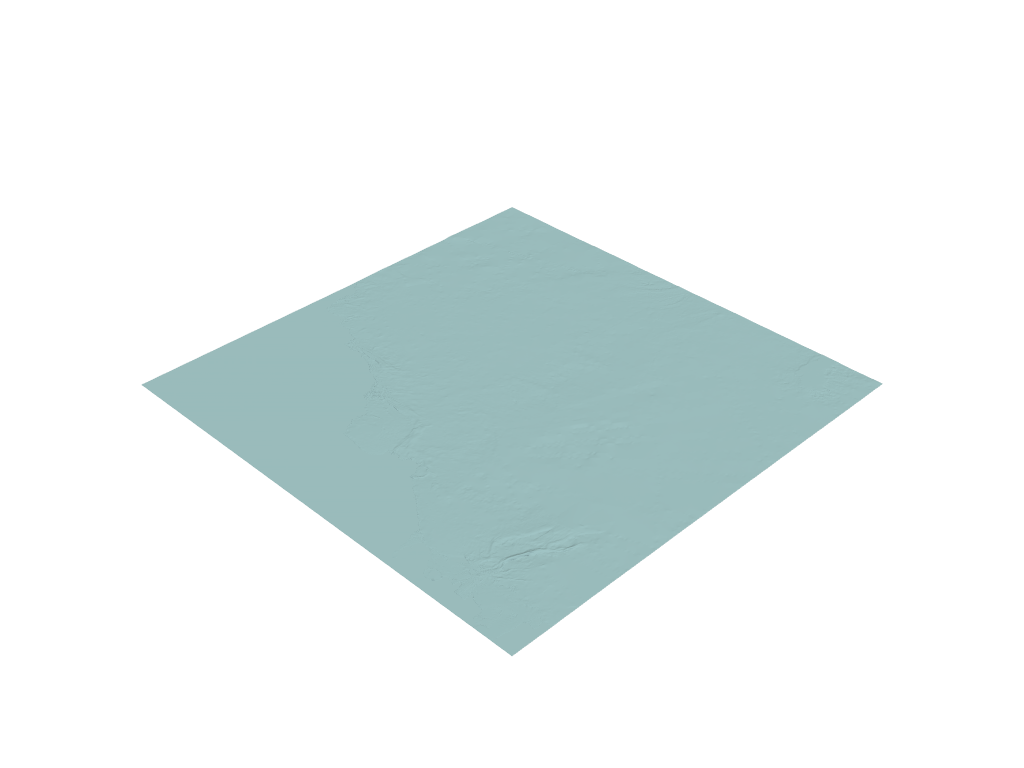

In [8]:
# https://pyvista.org/
import numpy as np
import pyvista as pv

# Get coordinates and values
x = bm_casey.x.values
y = bm_casey.y.values
z = bm_casey.thickness.values

# Create a structured surface
X, Y = np.meshgrid(x, y)
surf = pv.StructuredGrid(X, Y, z)

# Plot it
plotter = pv.Plotter()
plotter.add_mesh(surf, cmap='viridis', show_scalar_bar=True)
plotter.show()

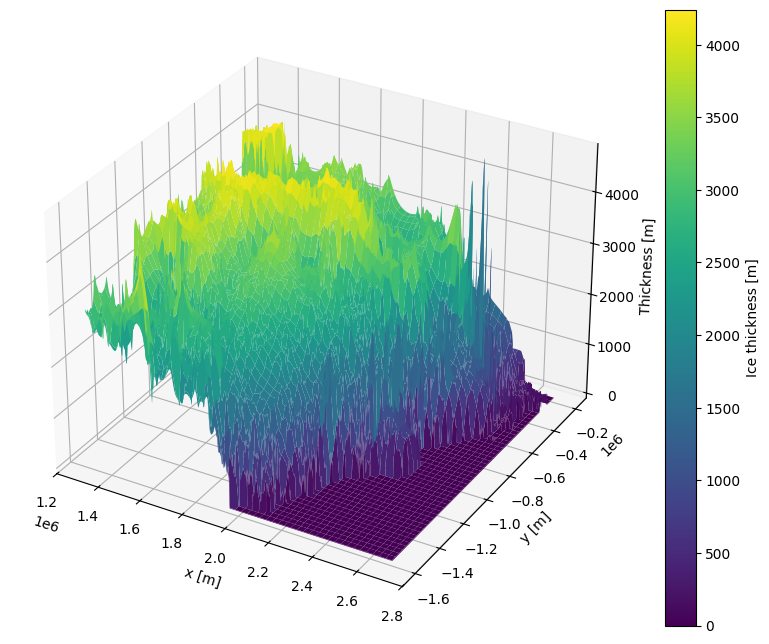

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection

# Extract coordinates and data
X = bm_casey.x.values
Y = bm_casey.y.values
Z = bm_casey.thickness.values

# Create meshgrid if not already
X2D, Y2D = np.meshgrid(X, Y)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X2D, Y2D, Z, cmap='viridis', linewidth=0, antialiased=True)
fig.colorbar(surf, ax=ax, label='Ice thickness [m]')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('Thickness [m]')
plt.show()

# Difference between BedMachien and measurements

In [24]:
# 8 M points
# NOTE: Now we perform minimal cleaning of the Bedmap3 data
# removed some Southern Stanford 71 survey points
ice = torch.load("data/ice_thickness_points_casey_aps.pt", weights_only = False).to(torch.float32)

In [25]:
ice

tensor([[ 1351898.7500, -1565267.1250,     2249.0000],
        [ 1305652.1250,  -479672.4688,     3223.0000],
        [ 1313427.3750,  -479702.8438,     3063.0000],
        ...,
        [ 1995202.5000,  -729995.1875,     3549.6599],
        [ 1995253.6250,  -729996.5625,     3551.6399],
        [ 1995278.5000,  -729997.1875,     3547.8799]])

In [26]:
# Initialise interpolator function (2D grid)
# NOTE: order of (y, x) for 2D grid
# By default will raise an error if a point is out of bounds
interp_fn = RegularGridInterpolator(
    (bm_casey.y.values, bm_casey.x.values), bm_casey.thickness.values,
)

# Make tensor numpy and reorder to (y, x)
points_for_interpol = ice.numpy()[:, [1, 0]]
values = interp_fn(points_for_interpol) 
ice_and_bm = torch.cat((ice, torch.tensor(values, dtype = torch.float32).unsqueeze(1)), dim = 1)

In [27]:
# Mean Absolute Error is 73 m 
(ice_and_bm[:, 2] - ice_and_bm[:, 3]).abs().mean()

tensor(71.3985)

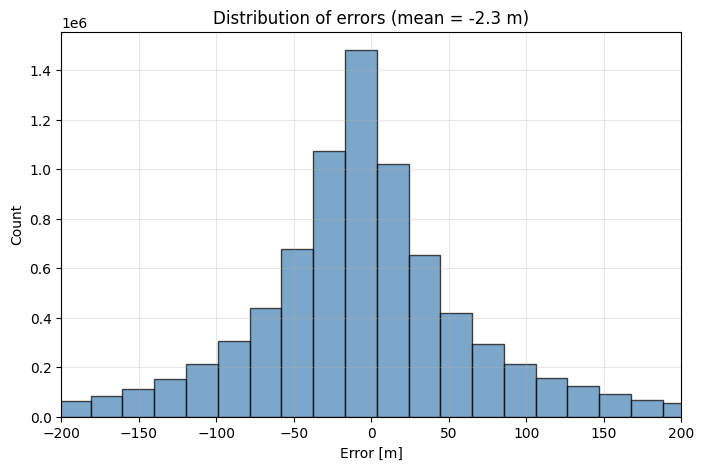

In [28]:
# Also check direction of errors
errors = (ice_and_bm[:, 2] - ice_and_bm[:, 3])

plt.figure(figsize = (8, 5))
plt.hist(errors, bins = 400, color = 'steelblue', edgecolor = 'k', alpha = 0.7)
plt.xlabel("Error [m]")
plt.ylabel("Count")
plt.title(f"Distribution of errors (mean = {errors.mean():.1f} m)")
plt.grid(alpha = 0.3)
plt.xlim(-200, 200)
plt.show()

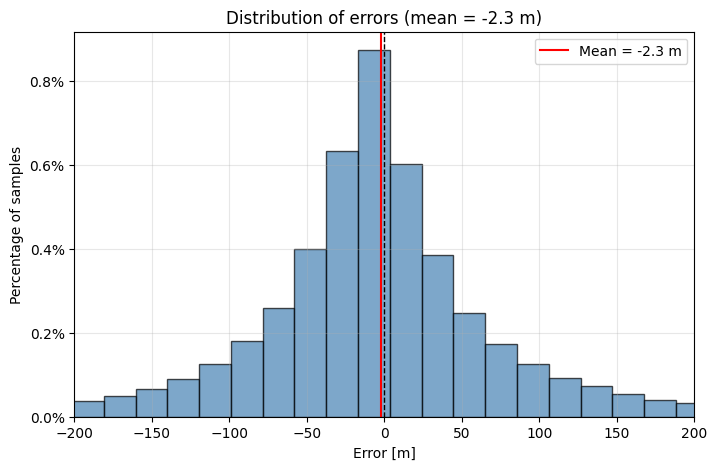

In [29]:
plt.figure(figsize = (8, 5))

# Use density=True to normalize area to 1, then multiply by 100 for %
counts, bins, patches = plt.hist(
    errors,
    bins = 400,
    color = 'steelblue',
    edgecolor = 'k',
    alpha = 0.7,
    density = True
)

# Scale y-axis ticks to percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y * 100:.1f}%"))

plt.xlabel("Error [m]")
plt.ylabel("Percentage of samples")
plt.title(f"Distribution of errors (mean = {errors.mean():.1f} m)")
plt.grid(alpha = 0.3)
plt.xlim(-200, 200)
plt.axvline(0, color = 'k', linestyle = '--', linewidth = 1)
plt.axvline(errors.mean(), color = 'r', linestyle = '-', linewidth = 1.5, label = f"Mean = {errors.mean():.1f} m")
plt.legend()
plt.show()


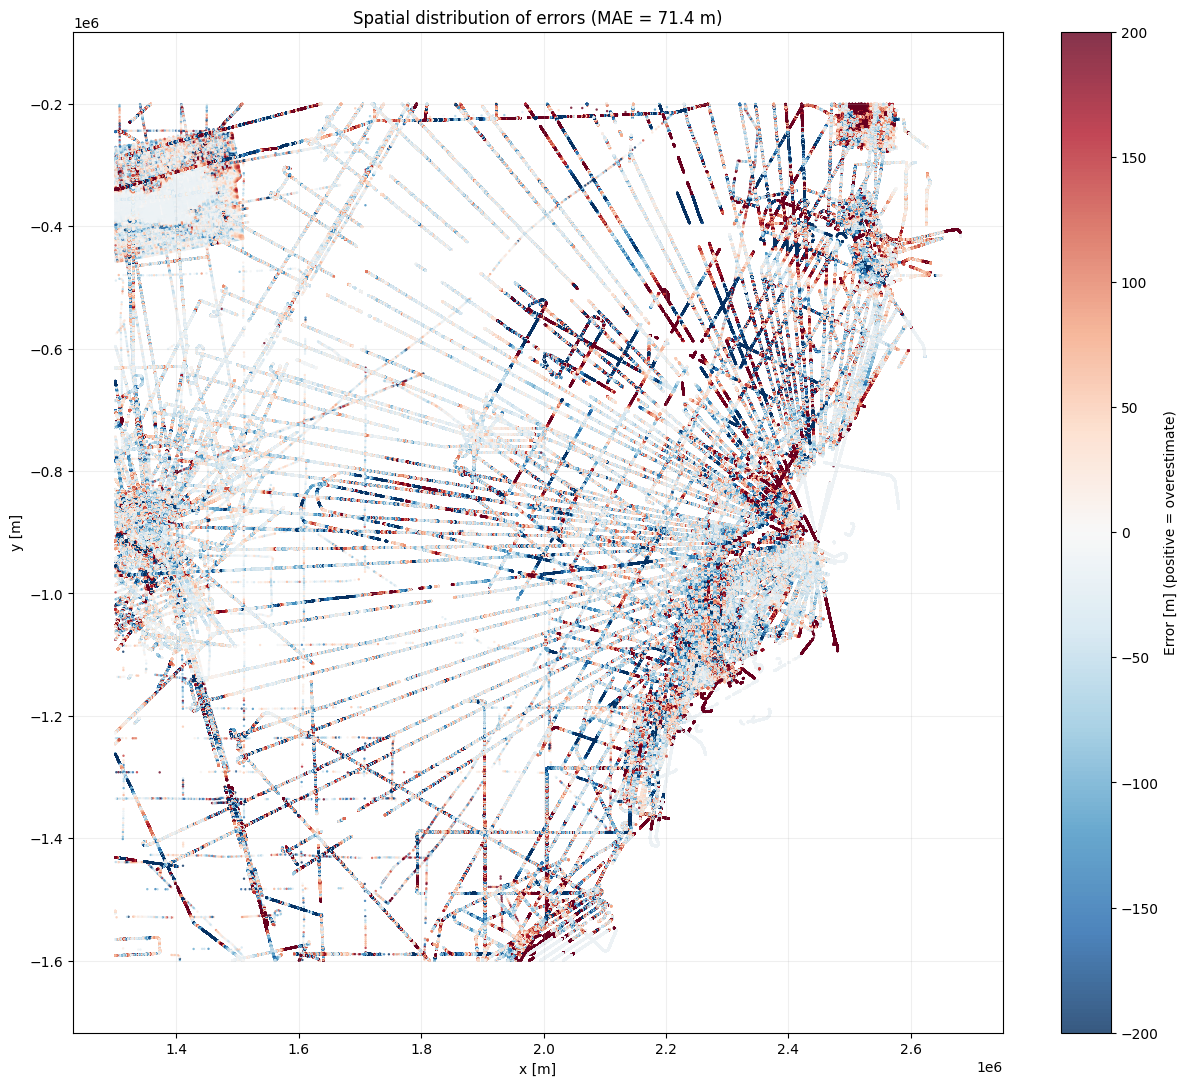

In [30]:
# Takes maybe 2 minutes on 8M points
# Compute signed errors
errors = (ice_and_bm[:, 2] - ice_and_bm[:, 3]).cpu().numpy()

x = ice_and_bm[:, 0].cpu().numpy()
y = ice_and_bm[:, 1].cpu().numpy()

plt.figure(figsize = (15, 13))
sc = plt.scatter(
    x, y,
    c = errors,
    cmap = "RdBu_r",
    vmin = -200, vmax = 200, 
    s = 3,                     
    alpha = 0.8,
    edgecolor = "none"
)

plt.colorbar(sc, label = "Error [m] (positive = overestimate)")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title(f"Spatial distribution of errors (MAE = {errors.__abs__().mean():.1f} m)")
plt.grid(alpha = 0.2)
plt.axis("equal")
plt.savefig("figures/spatial_error_Bedmachine.png", dpi = 300, bbox_inches = "tight")
plt.show()

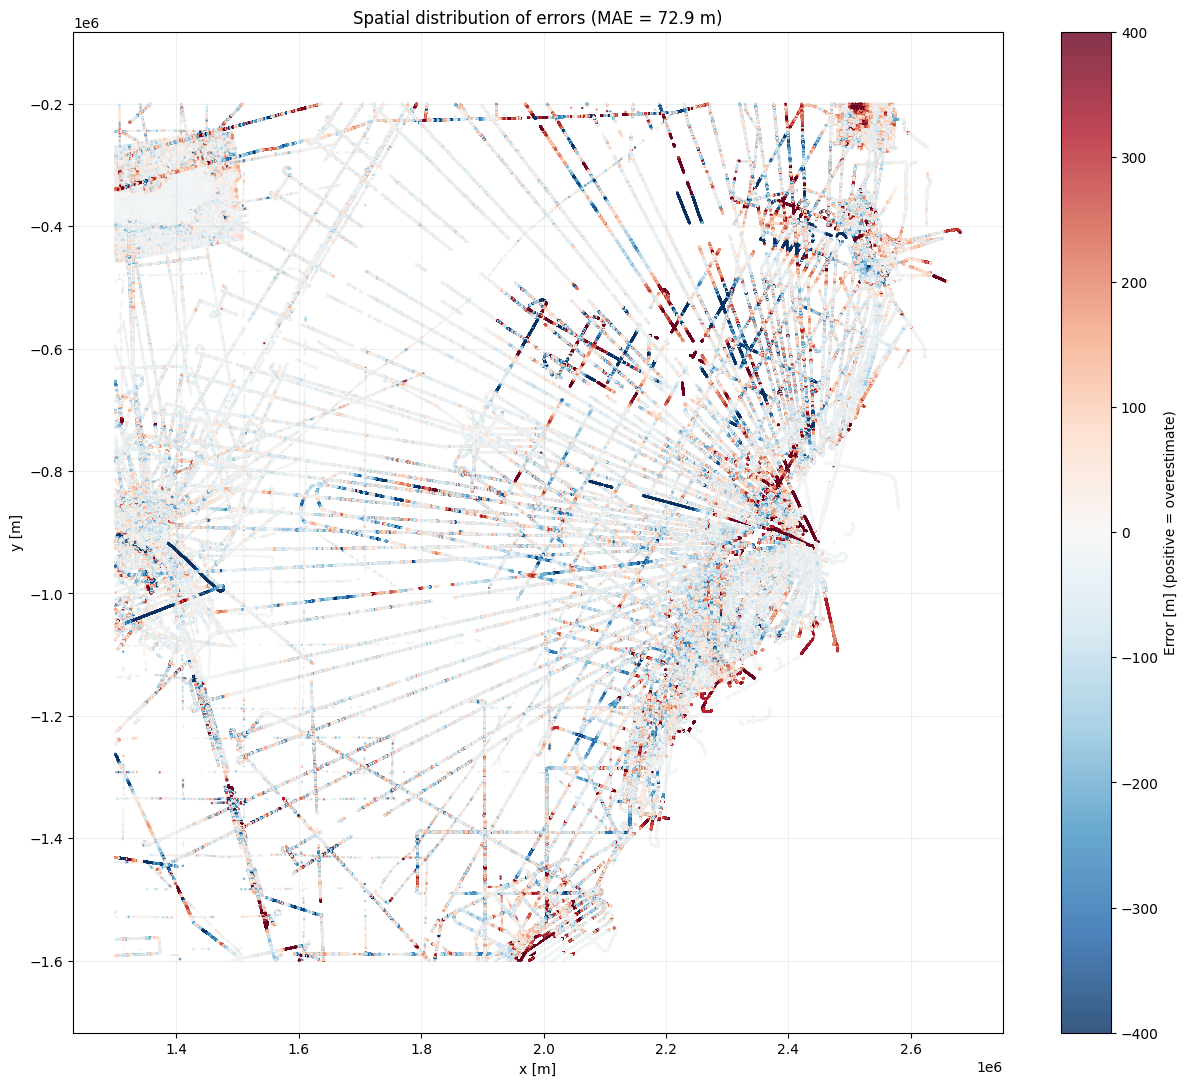

In [17]:
# Takes maybe 2 minutes on 8M points
# Compute signed errors
errors = (ice_and_bm[:, 2] - ice_and_bm[:, 3]).cpu().numpy()

x = ice_and_bm[:, 0].cpu().numpy()
y = ice_and_bm[:, 1].cpu().numpy()

plt.figure(figsize = (15, 13))
sc = plt.scatter(
    x, y,
    c = errors,
    cmap = "RdBu_r",
    vmin = - 400, vmax = 400, 
    s = 3,                     
    alpha = 0.8,
    edgecolor = "none"
)

plt.colorbar(sc, label = "Error [m] (positive = overestimate)")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title(f"Spatial distribution of errors (MAE = {errors.__abs__().mean():.1f} m)")
plt.grid(alpha = 0.2)
plt.axis("equal")
plt.savefig("figures/spatial_error_Bedmachine_400scale.png", dpi = 300, bbox_inches = "tight")
plt.show()

# Repeat for Bedmap3

In [18]:
bmap3

<xarray.Dataset> Size: 5GB
Dimensions:                 (x: 13334, y: 13334)
Coordinates:
  * x                       (x) float32 53kB -3.333e+06 -3.333e+06 ... 3.333e+06
  * y                       (y) float32 53kB 3.333e+06 3.333e+06 ... -3.333e+06
Data variables:
    surface_topography      (y, x) float32 711MB nan nan nan nan ... nan nan nan
    bed_uncertainty         (y, x) float32 711MB nan nan nan nan ... nan nan nan
    bed_topography          (y, x) float32 711MB nan nan nan nan ... nan nan nan
    mask                    (y, x) float32 711MB nan nan nan nan ... nan nan nan
    ice_thickness           (y, x) float32 711MB nan nan nan nan ... nan nan nan
    thickness_survey_count  (y, x) float32 711MB nan nan nan nan ... nan nan nan
    thickness_uncertainty   (y, x) float32 711MB nan nan nan nan ... nan nan nan
    mapping                 <U19 76B 'polar_stereographic'
Attributes: (12/26)
    crs:                    EPSG:3031
    title:                  BEDMAP3 - Ice thickness, bed and surface elevatio...
    summary:                We present here Bedmap3, the latest suite of grid...
    keywords:               Antarctica,BEDMAP,Elevation,Ice thickness
    Conventions:            ACDD-1.3, CF-1.8
    citation:               Pritchard, H., Fretwell, P., Fremand, A., Bodart,...
    ...                     ...
    time_coverage_end:      2024-11-01
    geospatial_lon_min:     -180
    geospatial_lon_max:     180
    geospatial_lat_min:     -90
    geospatial_lat_max:     -60
    geospatial_bounds_crs:  EPSG:4326

In [19]:
bmap3_casey

<xarray.Dataset> Size: 220MB
Dimensions:                 (x: 2800, y: 2800)
Coordinates:
  * x                       (x) float32 11kB 1.3e+06 1.301e+06 ... 2.7e+06
  * y                       (y) float32 11kB -2.002e+05 -2.008e+05 ... -1.6e+06
Data variables:
    surface_topography      (y, x) float32 31MB 3.705e+03 3.705e+03 ... nan nan
    bed_uncertainty         (y, x) float32 31MB 131.0 128.0 ... 165.0 169.0
    bed_topography          (y, x) float32 31MB 146.0 139.0 ... -4.198e+03
    mask                    (y, x) float32 31MB 1.0 1.0 1.0 1.0 ... nan nan nan
    ice_thickness           (y, x) float32 31MB 3.559e+03 3.566e+03 ... nan nan
    thickness_survey_count  (y, x) float32 31MB nan nan nan nan ... nan nan nan
    thickness_uncertainty   (y, x) float32 31MB 131.0 128.0 126.0 ... nan nan
    mapping                 <U19 76B 'polar_stereographic'
Attributes: (12/26)
    crs:                    EPSG:3031
    title:                  BEDMAP3 - Ice thickness, bed and surface elevatio...
    summary:                We present here Bedmap3, the latest suite of grid...
    keywords:               Antarctica,BEDMAP,Elevation,Ice thickness
    Conventions:            ACDD-1.3, CF-1.8
    citation:               Pritchard, H., Fretwell, P., Fremand, A., Bodart,...
    ...                     ...
    time_coverage_end:      2024-11-01
    geospatial_lon_min:     -180
    geospatial_lon_max:     180
    geospatial_lat_min:     -90
    geospatial_lat_max:     -60
    geospatial_bounds_crs:  EPSG:4326

In [31]:
interp_fn_bmap3 = RegularGridInterpolator(
    # NOTE: different name
    (bmap3_casey.y.values, bmap3_casey.x.values), bmap3_casey.ice_thickness.values,
    bounds_error = False,
    fill_value = np.nan,
)

# Make tensor numpy and reorder to (y, x)
points_for_interpol = ice.numpy()[:, [1, 0]]
values_bmap3 = interp_fn_bmap3(points_for_interpol) 
ice_and_bmap3 = torch.cat((ice, torch.tensor(values_bmap3, dtype = torch.float32).unsqueeze(1)), dim = 1)

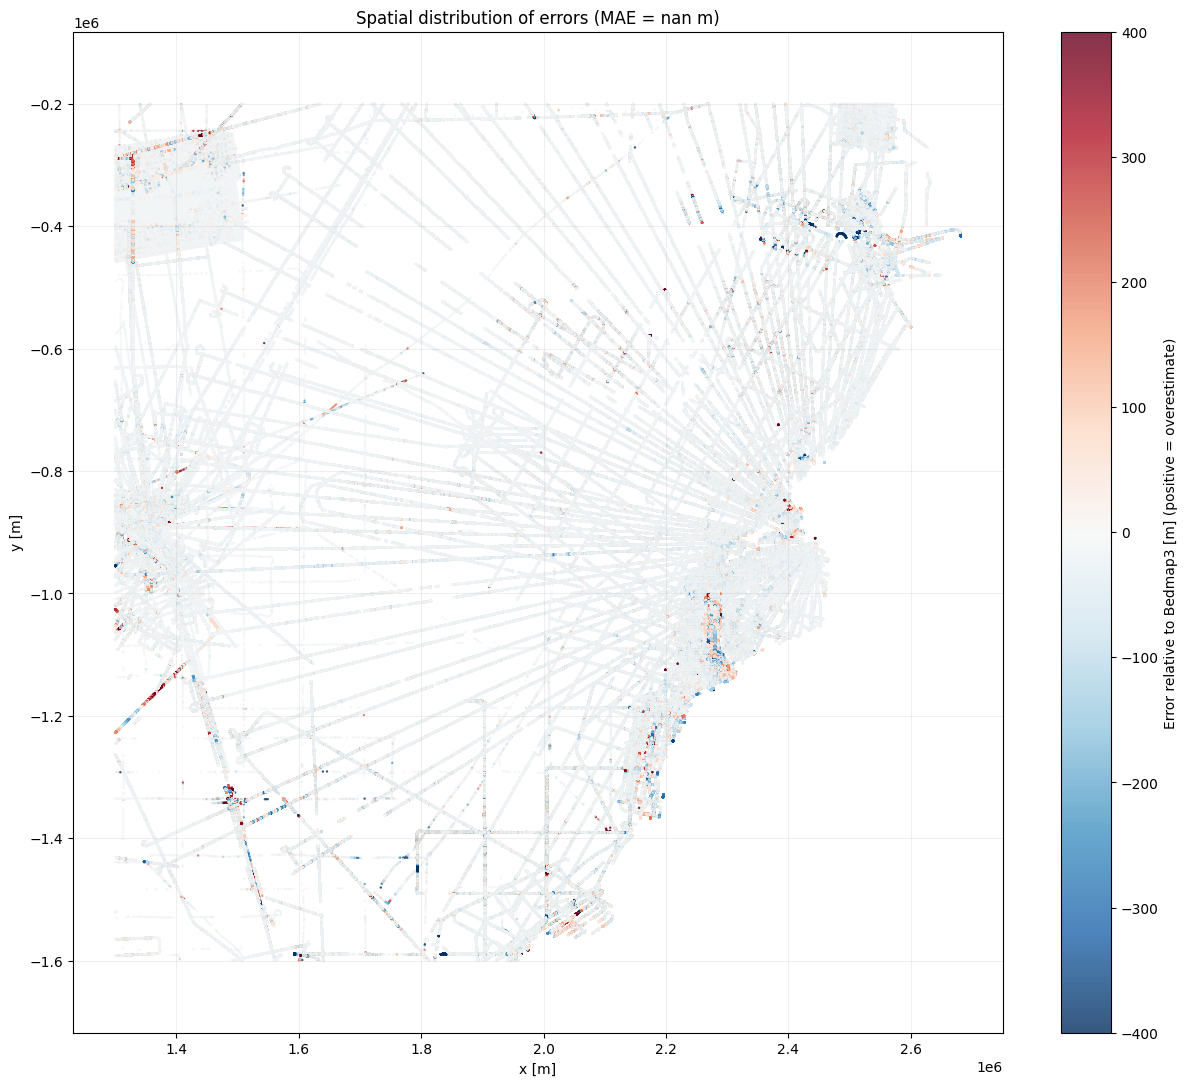

In [32]:
# Takes maybe 2 minutes on 8M points
# Compute signed errors
errors_bmap3 = (ice_and_bmap3[:, 2] - ice_and_bmap3[:, 3]).cpu().numpy()

x = ice_and_bmap3[:, 0].cpu().numpy()
y = ice_and_bmap3[:, 1].cpu().numpy()

plt.figure(figsize = (15, 13))
sc = plt.scatter(
    x, y,
    c = errors_bmap3,
    cmap = "RdBu_r",
    vmin = - 400, vmax = 400, 
    s = 3,                     
    alpha = 0.8,
    edgecolor = "none"
)

plt.colorbar(sc, label = "Error relative to Bedmap3 [m] (positive = overestimate)")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title(f"Spatial distribution of errors (MAE = {errors_bmap3.__abs__().mean():.1f} m)")
plt.grid(alpha = 0.2)
plt.axis("equal")
plt.savefig("figures/spatial_error_Bedmap3_400scale.png", dpi = 300, bbox_inches = "tight")
plt.show()

# Data cleaning

/tmp/ipykernel_12820/1148205152.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  sc = plt.scatter(


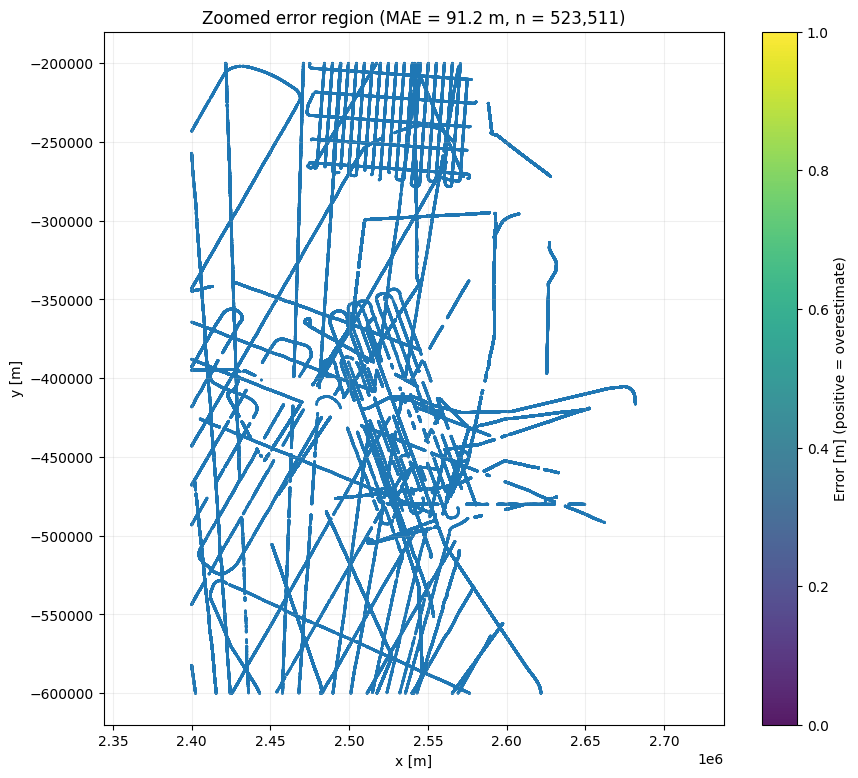

In [23]:
x_min_zoom = 2_400_000
x_max_zoom = 2_700_000
y_min_zoom = - 600_000
y_max_zoom = - 200_000

mask = (
    (x >= x_min_zoom) & (x <= x_max_zoom) &
    (y >= y_min_zoom) & (y <= y_max_zoom)
)

x_zoom = x[mask]
y_zoom = y[mask]
errors_zoom = errors[mask]

plt.figure(figsize = (10, 9))
sc = plt.scatter(
    x_zoom, y_zoom,
    # c = errors_zoom,
    cmap = "RdBu_r",
    vmin = -400, vmax = 400,
    s = 4,
    alpha = 0.9,
    edgecolor = "none"
)
plt.colorbar(sc, label = "Error [m] (positive = overestimate)")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title(f"Zoomed error region (MAE = {abs(errors_zoom).mean():.1f} m, n = {len(x_zoom):,})")
plt.grid(alpha = 0.2)
plt.axis("equal")
plt.show()

In [ ]:
x_min_zoom = 1_450_000
x_max_zoom = 1_470_000
y_min_zoom = - 1_000_000
y_max_zoom = - 990_000

mask = (
    (x >= x_min_zoom) & (x <= x_max_zoom) &
    (y >= y_min_zoom) & (y <= y_max_zoom)
)

x_zoom = x[mask]
y_zoom = y[mask]
errors_zoom = errors[mask]

plt.figure(figsize = (10, 9))
sc = plt.scatter(
    x_zoom, y_zoom,
    c = errors_zoom,
    cmap = "RdBu_r",
    vmin = -400, vmax = 400,
    s = 4,
    alpha = 0.9,
    edgecolor = "none"
)
plt.colorbar(sc, label = "Error [m] (positive = overestimate)")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title(f"Zoomed error region (MAE = {abs(errors_zoom).mean():.1f} m, n = {len(x_zoom):,})")
plt.grid(alpha = 0.2)
plt.axis("equal")
plt.show()

If full lines are wrong that would indicate that there is bias in the data. This may help for some data cleaning...

# Sequential on 